This model combines different approaches. First, MSTL is used to decompose the time series into multiple seasonalities (daily, weekly, yearly). An ARIMA model is used to predict the residuals. For the trend, we take the last known value and assume it stays the same for the 28 days we want to predict. For the daily seasonality, and XGB model is tuned using the weather data, while the weekly and yearly seasonalities are simply predicted using a NAIVE forecasting approach.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [16]:
data = pd.read_pickle('../00_Data/data_full_with_holiday.pkl')

data['DATETIME'] = data.index
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data = data.asfreq('30T')

data['year'] = data['DATETIME'].dt.year
data['month'] = data['DATETIME'].dt.month
data['day'] = data['DATETIME'].dt.day
data['hour'] = data['DATETIME'].dt.hour
data['min'] = data['DATETIME'].dt.minute
data = data.drop(['DATETIME'], axis=1)

In [17]:
data_train = data.loc[data.index < '2023-10-30']
data_test = data.loc[data.index >= '2023-10-30']

In [18]:
X_train = data_train.drop('demand', axis=1)
X_test = data_test.drop('demand', axis=1)

y_train = data_train['demand']
y_train.name = 'Actual demand (train)'
y_test = data_test['demand']
y_test.name = 'Actual demand (test)'

In [5]:
mstl = pd.read_pickle('mstl.pkl')

# Model Implementation

In [13]:
import pmdarima as pm
import xgboost as xgb

In [7]:
mstl.head()

,observed,trend,seasonal_48,seasonal_336,seasonal_17532,resid
2020-12-01 00:00:00+00:00,26812.0,29692.475716,-8362.699420,741.833933,4629.827277,110.562494
2020-12-01 00:30:00+00:00,26886.0,29692.460542,-8191.134552,793.948470,4507.407840,83.317700
2020-12-01 01:00:00+00:00,26473.0,29692.445368,-8455.688150,640.828705,4639.838801,-44.424724
2020-12-01 01:30:00+00:00,26105.0,29692.430195,-8820.355187,529.242237,4735.167314,-31.484559
2020-12-01 02:00:00+00:00,25861.0,29692.415023,-9269.873731,510.807873,4941.538162,-13.887327


In [8]:
y_resid_train = mstl['resid']

In [9]:
arima_resid = pm.auto_arima(y_resid_train, seasonal=False, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

print(arima_resid.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=44.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=656143.514, Time=0.98 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=652749.116, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=653087.276, Time=3.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=656141.514, Time=0.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=652684.336, Time=1.49 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=652642.650, Time=2.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=652470.299, Time=2.76 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=652452.402, Time=3.99 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=89550.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=652267.039, Time=52.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=108.95 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=651363.699, Time=146.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=652270.785, Time=42.29 sec
 ARIMA(5,1,2)(0

In [12]:
y_season48_train = mstl['seasonal_48']

In [15]:
tscv = TimeSeriesSplit(n_splits=6)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, 
                                   n_iter=100, cv=tscv, verbose=2, n_jobs=-1, 
                                   scoring='neg_mean_squared_error')

In [19]:
random_search.fit(X_train, y_season48_train)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error', verbose=2)

In [20]:
best_model = random_search.best_estimator_

## Prediction

In [21]:
resid_pred = arima_resid.predict(len(X_test))
resid_pred = pd.Series(resid_pred, index=X_test.index)

season48_pred = best_model.predict(X_test)
season48_pred = pd.Series(season48_pred, index=X_test.index)

last_trend_value = mstl['trend'].iloc[-1]
trend_pred = pd.Series([last_trend_value] * len(X_test), index=X_test.index)

seasonal336_pred = pd.Series(index=X_test.index, dtype=float)
seasonal17532_pred = pd.Series(index=X_test.index, dtype=float)
for i in range(len(X_test)):
    idx336 = (i - 336) % 336
    seasonal336_pred.iloc[i] = mstl['seasonal_336'].iloc[idx336]

    idx17532 = (i - 17532) % 17532
    seasonal17532_pred.iloc[i] = mstl['seasonal_17532'].iloc[idx17532]

In [23]:
resid_pred, season48_pred, trend_pred, seasonal336_pred, seasonal17532_pred

(2023-10-30 00:00:00+00:00    482.151951
 2023-10-30 00:30:00+00:00    488.856106
 2023-10-30 01:00:00+00:00    503.566495
 2023-10-30 01:30:00+00:00    506.244557
 2023-10-30 02:00:00+00:00    516.009600
                                 ...    
 2023-11-29 22:00:00+00:00    584.186580
 2023-11-29 22:30:00+00:00    584.186580
 2023-11-29 23:00:00+00:00    584.186580
 2023-11-29 23:30:00+00:00    584.186580
 2023-11-30 00:00:00+00:00    584.186580
 Freq: 30T, Length: 1489, dtype: float64,
 2023-10-30 00:00:00+00:00   -5289.562012
 2023-10-30 00:30:00+00:00   -5109.676758
 2023-10-30 01:00:00+00:00   -5208.369141
 2023-10-30 01:30:00+00:00   -5574.990723
 2023-10-30 02:00:00+00:00   -5679.175781
                                 ...     
 2023-11-29 22:00:00+00:00   -1686.191284
 2023-11-29 22:30:00+00:00   -3516.395264
 2023-11-29 23:00:00+00:00   -4580.417969
 2023-11-29 23:30:00+00:00   -5383.733398
 2023-11-30 00:00:00+00:00   -5739.291504
 Freq: 30T, Length: 1489, dtype: float32,
 20

In [22]:
full_prediction = resid_pred + season48_pred + trend_pred + seasonal336_pred + seasonal17532_pred

## Prediction Statistics

In [24]:
y_pred_s = pd.Series(full_prediction, index=y_test.index, name='Predicted demand (test)')

### 24 Hours Forecast

In [26]:
y_pred_48 = y_pred_s.iloc[:48]
y_test_48 = y_test.iloc[:48]

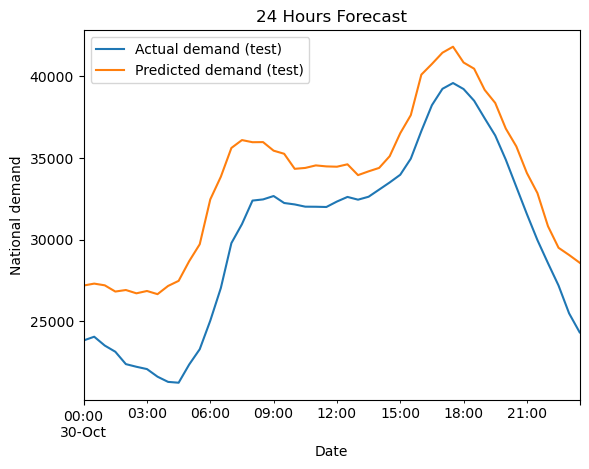

In [27]:
fig, ax = plt.subplots()
y_test_48.plot(ax=ax)
y_pred_48.plot(ax=ax)
ax.legend()
ax.set_title('24 Hours Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [28]:
print(f'RMSE for 24 hours: {mean_squared_error(y_test_48, y_pred_48, squared=False)}')

RMSE for 24 hours: 3693.6504209712266


### 7 Days Prediction

In [29]:
y_pred_336 = y_pred_s.iloc[:336]
y_test_336 = y_test.iloc[:336]

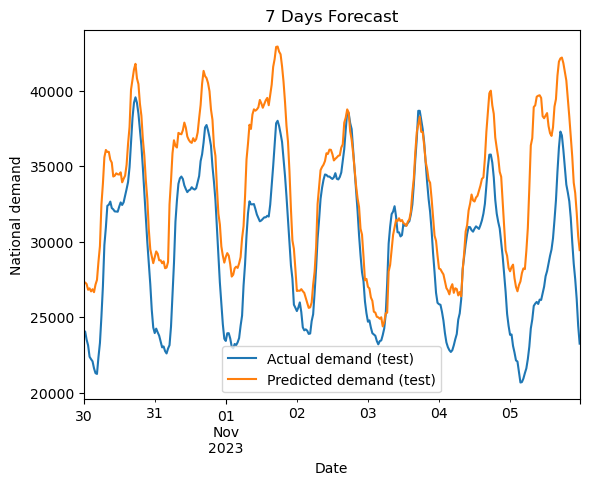

In [30]:
fig, ax = plt.subplots()
y_test_336.plot(ax=ax)
y_pred_336.plot(ax=ax)
ax.legend()
ax.set_title('7 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [31]:
print(f'RMSE for 7 days: {mean_squared_error(y_test_336, y_pred_336, squared=False)}')

RMSE for 7 days: 4652.373043314456


### 28 Days Prediction

In [32]:
y_pred_1344 = y_pred_s.iloc[:1344]
y_test_1344 = y_test.iloc[:1344]

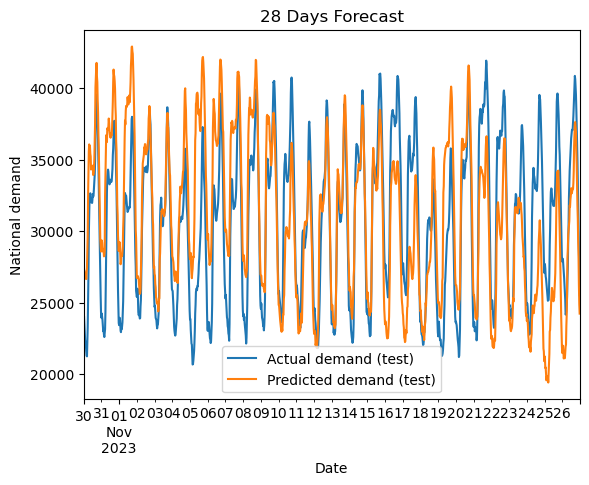

In [33]:
fig, ax = plt.subplots()
y_test_1344.plot(ax=ax)
y_pred_1344.plot(ax=ax)
ax.legend()
ax.set_title('28 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [34]:
print(f'RMSE for 28 days: {mean_squared_error(y_test_1344, y_pred_1344, squared=False)}')

RMSE for 28 days: 4149.496234736311
